<a href="https://colab.research.google.com/github/neevenajs/proba/blob/main/predikcijaSuicida.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#!pip install scipy>=1.7.1
#!pip install dython
import pandas as pd
pd.__version__
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import scipy as stats
#import dython
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
#from dython import nominal
import tensorflow as tf
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score, f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
#import scikitplot as skplt
from sklearn.metrics import roc_curve, plot_roc_curve
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# povezi sa google drive
from google.colab import drive
drive.mount('/content/gdrive')
!ls "/content/gdrive/My Drive/Predikcija suicida"

Mounted at /content/gdrive
 Aptrakt.docx		  'Radna tabela.gsheet'
 predikcijaSuicida.ipynb  'Предикција степена ризика суицидног понашања.docx'
'Radna tabela.csv'


In [ ]:
data = pd.read_csv("/content/gdrive/My Drive/Predikcija suicida/Radna tabela.csv")
#data=pd.read_csv("radna_tabela.csv", sep='\t', engine='python')
print(data.shape)
print(data.info())

data.head()
NANs = data.isnull().sum()
print(NANs)
udeo = data.isnull().sum()/len(data)*100
print("\n Procenat NaN: \n", udeo)
print(len(data[data['Stepen rizika']==1]))

(305, 26)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305 entries, 0 to 304
Data columns (total 26 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Pol                                   304 non-null    object 
 1   Starost                               305 non-null    int64  
 2   Radni status                          259 non-null    object 
 3   Bračni status                         251 non-null    object 
 4   Obrazovni status                      128 non-null    object 
 5   Broj dana hospitalizacije             304 non-null    float64
 6   Pozitivna porodična anamneza          189 non-null    object 
 7   Broj pokušaja suicida                 258 non-null    float64
 8   Broj hospitalizacija                  244 non-null    float64
 9   Ranije lečenje                        295 non-null    object 
 10  Telesni komorbiditet                  305 non-null    object 
 11  Broj član

In [ ]:
#nominal.associations(data, figsize=(30,40),mark_columns=True)
# drop columns with more than 40% missing data
#data.drop(['Obrazovni status','Metod pokušaja suicida', 'Materijalni status', 'Iskustvo zlostavljanja/zanemarivanja', 'Agresivnost/impulsivnost', 'Emocionalna nestabilnost','Pozitivna porodična anamneza '], axis=1, inplace=True)
del data['Obrazovni status']
del data['Materijalni status']
del data['Iskustvo zlostavljanja/zanemarivanja']
del data['Agresivnost/impulsivnost']
del data['Emocionalna nestabilnost']
del data['Pozitivna porodična anamneza ']
del data['Metod pokušaja suicida']
print('% of missing values:\n', data.isnull().sum()/len(data)*100)
print()
print(data.shape)

data.dropna(subset=['Pol', 'Broj dana hospitalizacije', 'Mesto stanovanja'], axis=0, inplace=True)
data.shape

print("Procenat nedostajucih podataka: \n", data.isnull().sum()/len(data)*100)



% of missing values:
 Pol                           0.327869
Starost                       0.000000
Radni status                 15.081967
Bračni status                17.704918
Broj dana hospitalizacije     0.327869
Broj pokušaja suicida        15.409836
Broj hospitalizacija         20.000000
Ranije lečenje                3.278689
Telesni komorbiditet          0.000000
Broj članova domaćinstva     27.540984
Broj dece                    23.606557
Mesec pokušaja                0.000000
Dan u nedelji                 0.000000
Mesto stanovanja              0.655738
Upotreba alkohola             0.000000
Vodeća dijagnoza              0.000000
Prateća dijagnoza            23.278689
Razlog pokušaja suicida      14.098361
Stepen rizika                 0.000000
dtype: float64

(305, 19)
Procenat nedostajucih podataka: 
 Pol                           0.000000
Starost                       0.000000
Radni status                 15.282392
Bračni status                17.940199
Broj dana hospitaliza

In [ ]:
#data = data.apply(lambda x:x.fillna(x.value_counts().index[0]))
data = data.apply(lambda x: x.astype(str).str.lower())

#bracni status i radni status: nan menjam sa no info
data['Bračni status'].replace('nan', 'no info', inplace=True)
data['Radni status'].replace('nan', 'no info', inplace=True)
#razlog pokusaja suicida: nan prebacujem u /
#u ovom obelezju smo imali kategoriju neodredjeno, no info i /, pa sam sve prebacila u neodredjeno, jer znaci isto
data['Razlog pokušaja suicida'].replace('nan','neodređeno', inplace=True)
#prateca dijagnoza: nan zamenjujem novom kategorijom 'ne postoji'
data['Prateća dijagnoza'].replace('nan', 'ne postoji', inplace=True)
#broj dece: zamenjujem zaokruzenom srednjom vrednoscu
data['Broj dece']=data['Broj dece'].astype(str).astype(float)
data['Broj dece']=data['Broj dece'].fillna(round(data['Broj dece'].mean()))
#broj clanova domacinstva: zamenjuje zaokruzenom srednjom vrednoscu
data['Broj članova domaćinstva'].replace('beskućnik', 0, inplace=True)
data['Broj članova domaćinstva']=data['Broj članova domaćinstva'].astype(str).astype(float)
data['Broj članova domaćinstva'].fillna(round(data['Broj članova domaćinstva'].mean()), inplace=True)
#broj hospitalizacija: nan menjam srednjom vrednoscu
data['Broj hospitalizacija']=data['Broj hospitalizacija'].astype(str).astype(float)
data['Broj hospitalizacija'].fillna(round(data['Broj hospitalizacija'].mean()), inplace=True)
#ranije lecenje: nan menjam sa 'no info'
data['Ranije lečenje'].replace('nan', 'no info', inplace=True)
#broj pokusaja suicida: nan menjam srednjom vrednoscu
data['Broj pokušaja suicida']=data['Broj pokušaja suicida'].astype(str).astype(float)
data['Broj pokušaja suicida'].fillna(round(data['Broj pokušaja suicida'].mean()), inplace=True)
#kod metode pokusaja suicida menjam nan sa ne postoji zato sto su to u pitanju pacijenti niskog rizika
#data['Metod pokušaja suicida'].replace('nan', 'ne postoji', inplace=True)
data['Broj dana hospitalizacije']=data['Broj dana hospitalizacije'].astype(str).astype(float)
print(data.info())
print("Procenat nedostajucih podataka: \n", data.isnull().sum()/len(data)*100)
data['Stepen rizika']=data['Stepen rizika'].astype(str).astype(float)
data['Starost']=data['Starost'].astype(str).astype(float)
data.head()
print(data.info())

data.head()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 301 entries, 0 to 304
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pol                        301 non-null    object 
 1   Starost                    301 non-null    object 
 2   Radni status               301 non-null    object 
 3   Bračni status              301 non-null    object 
 4   Broj dana hospitalizacije  301 non-null    float64
 5   Broj pokušaja suicida      301 non-null    float64
 6   Broj hospitalizacija       301 non-null    float64
 7   Ranije lečenje             301 non-null    object 
 8   Telesni komorbiditet       301 non-null    object 
 9   Broj članova domaćinstva   301 non-null    float64
 10  Broj dece                  301 non-null    float64
 11  Mesec pokušaja             301 non-null    object 
 12  Dan u nedelji              301 non-null    object 
 13  Mesto stanovanja           301 non-null    object 

,Pol,Starost,Radni status,Bračni status,Broj dana hospitalizacije,Broj pokušaja suicida,Broj hospitalizacija,Ranije lečenje,Telesni komorbiditet,Broj članova domaćinstva,Broj dece,Mesec pokušaja,Dan u nedelji,Mesto stanovanja,Upotreba alkohola,Vodeća dijagnoza,Prateća dijagnoza,Razlog pokušaja suicida,Stepen rizika
0,ž,42.0,zaposlen/a,neoženjen/neudata,29.0,2.0,2.0,da,nema,3.0,0.0,januar,utorak,grad,ne,f3,f6,neodređeno,1.0
1,m,58.0,zaposlen/a,razveden/a,11.0,0.0,0.0,ne,kardiovaskularne bolesti,2.0,1.0,januar,petak,selo,da,f4,f1,porodični problemi,1.0
2,m,40.0,no info,no info,8.0,1.0,1.0,no info,nepoznato,3.0,1.0,januar,četvrtak,selo,da,f6,f1,neodređeno,1.0
3,ž,51.0,zaposlen/a,vanbračna zajednica,10.0,2.0,2.0,da,endokrinološke bolesti,2.0,0.0,januar,petak,grad,da,f6,ne postoji,neodređeno,1.0
4,m,59.0,zaposlen/a,oženjen/udata,15.0,1.0,1.0,da,nema,3.0,0.0,februar,sreda,grad,da,f6,ne postoji,porodični problemi,1.0


/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


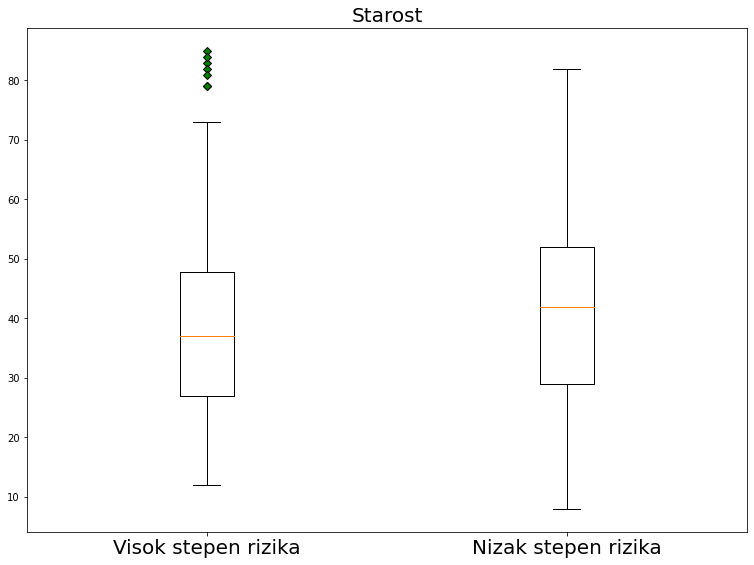

count    301.000000
mean      39.906977
std       16.062108
min        8.000000
25%       28.000000
50%       39.000000
75%       50.000000
max       85.000000
Name: Starost, dtype: float64
count    301.000000
mean       1.000000
std        1.726268
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max       20.000000
Name: Broj pokušaja suicida, dtype: float64
count    301.000000
mean      11.136213
std        9.037591
min        1.000000
25%        4.000000
50%        8.000000
75%       16.000000
max       51.000000
Name: Broj dana hospitalizacije, dtype: float64
ž
45.0
nezaposlen/a
neoženjen/neudata
7.0
0.0
0.0
da
nema
3.0
0.0
okt
četvrtak
grad
ne
f2
f2
/


In [ ]:
visokiRizik=data[data['Stepen rizika']==1]
nizakRizik=data[data['Stepen rizika']==0]
podaci1=visokiRizik['Starost']
podaci2=nizakRizik['Starost']
podaci=[podaci1, podaci2]
green_diamond = dict(markerfacecolor='g', marker='D')
fig=plt.figure(figsize=(10,7))
ax = fig.add_axes([0, 0, 1, 1])
ax.set_title('Starost', fontsize=20)
bp=ax.boxplot(podaci, flierprops=green_diamond, labels=['Visok stepen rizika', 'Nizak stepen rizika'])
ax.set_xticklabels(labels=['Visok stepen rizika', 'Nizak stepen rizika'], fontsize=20)
plt.show()

print(data['Starost'].describe())
print(data['Broj pokušaja suicida'].describe())
print(data['Broj dana hospitalizacije'].describe())

print(nizakRizik['Pol'].value_counts().idxmax())                          
print(nizakRizik['Starost'].value_counts().idxmax())                     
print(nizakRizik['Radni status'].value_counts().idxmax())                 
print(nizakRizik['Bračni status'].value_counts().idxmax())               
print(nizakRizik['Broj dana hospitalizacije'].value_counts().idxmax())   
print(nizakRizik['Broj pokušaja suicida'].value_counts().idxmax())   
print(nizakRizik['Broj hospitalizacija'].value_counts().idxmax())                          
print(nizakRizik['Ranije lečenje'].value_counts().idxmax())                     
print(nizakRizik['Telesni komorbiditet'].value_counts().idxmax())                 
print(nizakRizik['Broj članova domaćinstva'].value_counts().idxmax())               
print(nizakRizik['Broj dece'].value_counts().idxmax())   
print(nizakRizik['Mesec pokušaja'].value_counts().idxmax()) 
print(nizakRizik['Dan u nedelji'].value_counts().idxmax())                          
print(nizakRizik['Mesto stanovanja'].value_counts().idxmax())                     
print(nizakRizik['Upotreba alkohola'].value_counts().idxmax())                 
print(nizakRizik['Vodeća dijagnoza'].value_counts().idxmax())               
print(nizakRizik['Prateća dijagnoza'].value_counts().idxmax())   
print(nizakRizik['Razlog pokušaja suicida'].value_counts().idxmax()) 
#print(nizakRizik['Metod pokušaja suicida'].value_counts().idxmax())
#print(visokiRizik['Metod pokušaja suicida'].value_counts())


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


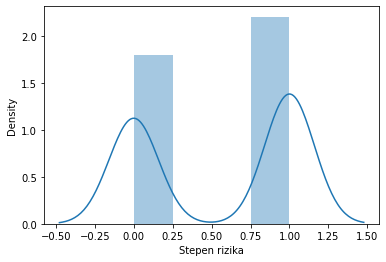

    Pol  Radni status  ... Prateća dijagnoza Razlog pokušaja suicida
0     ž    zaposlen/a  ...                f6              neodređeno
1     m    zaposlen/a  ...                f1      porodični problemi
2     m       no info  ...                f1              neodređeno
3     ž    zaposlen/a  ...        ne postoji              neodređeno
4     m    zaposlen/a  ...        ne postoji      porodični problemi
..   ..           ...  ...               ...                     ...
300   ž  nezaposlen/a  ...                f7                       /
301   ž  penzioner/ka  ...                f0                       /
302   ž    učenik/ica  ...        ne postoji                       /
303   ž    zaposlen/a  ...        ne postoji                       /
304   m    učenik/ica  ...                f3                       /

[301 rows x 12 columns]
7    32.0
Name: Starost, dtype: float64
sept        21
januar      17
november    17
december    17
june        16
okt         16
februar     13
ma

In [ ]:
Y1=data.iloc[:, -1]
#histogram
sb.distplot(Y1)
plt.show()
X1 = data.iloc[:, :-1]

numerical_feats = X1.dtypes[X1.dtypes != "object"]
#print(numerical_feats)
categoricalFeatures = X1.select_dtypes(include=['object']).copy()
#categoricalFeatures.head()
print(categoricalFeatures)
column=list(X1)
#data = data.apply(lambda x: x.astype(str).str.lower())

for columns in data:
  uniqueValues = data[columns].unique()
  #print(uniqueValues)

#print(data.isnull().sum().sum())
#data.head()
#data = data.apply(lambda x: x.astype(str).str.lower()
#print(data['Razlog pokušaja suicida'].value_counts().idxmax())
visokiRizik_kat=data[data['Stepen rizika']==1]
ekstrem=visokiRizik_kat[visokiRizik_kat['Broj pokušaja suicida']==20]
print(ekstrem['Starost'])
print(visokiRizik_kat['Mesec pokušaja'].value_counts())
razlog=visokiRizik_kat[visokiRizik_kat['Razlog pokušaja suicida']=='porodični problemi']
#print(razlog['Broj dece'].value_counts())
#pacijentSamotrovanje=visokiRizik_kat[visokiRizik_kat['Metod pokušaja suicida']=='skakanje sa visine']
#upotrebaAlkohola=visokiRizik_kat[visokiRizik_kat['Upotreba alkohola']=='da']
#print(pacijentSamotrovanje['Vodeća dijagnoza'].value_counts())
#nePostoji=data[data['Metod pokušaja suicida']!='ne postoji']
#nisuRanije=nePostoji[nePostoji['Broj pokušaja suicida']==0]
#print(nisuRanije['Razlog pokušaja suicida'].value_counts())

In [ ]:
corr = data.iloc[:,:-1].corr(method = 'pearson')
plt.figure(figsize=(12,9))
sb.set(font_scale=1.9)
sb.heatmap(corr, annot=True, annot_kws={"fontsize":17})
import scipy.stats

r, p = scipy.stats.spearmanr(data)
#print(p)

#prikazujem korelaciju izmedju varijabli (sortirano)
c = data.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort")
#print(so)

In [ ]:
data.dtypes

Pol                           object
Starost                      float64
Radni status                  object
Bračni status                 object
Broj dana hospitalizacije    float64
Broj pokušaja suicida        float64
Broj hospitalizacija         float64
Ranije lečenje                object
Telesni komorbiditet          object
Broj članova domaćinstva     float64
Broj dece                    float64
Mesec pokušaja                object
Dan u nedelji                 object
Mesto stanovanja              object
Upotreba alkohola             object
Vodeća dijagnoza              object
Prateća dijagnoza             object
Razlog pokušaja suicida       object
Stepen rizika                float64
dtype: object

In [ ]:
# catg to num
catg_list = data.dtypes[data.dtypes == "object"].index.tolist() 
data1=pd.DataFrame()
for catg in catg_list:
    X_temp = pd.get_dummies(data[catg], prefix=catg).iloc[:, :-1]
    data1 = pd.concat([data1, X_temp], axis=1)
num_list = data.dtypes[data.dtypes != "object"].index.tolist()
data1 = pd.concat([data1, data[num_list]], axis=1)
data1 = data1.astype('float')
print(data1.columns)
print(data1.shape)
encode_data = data1
encode_data.head()

In [ ]:
#prikaz podataka: 
visokiRizik=encode_data.loc[encode_data['Stepen rizika']==1]
print(visokiRizik_kat.info())
visokiRizik_kat=data.loc[data['Stepen rizika']==1]
#posmatramo kako su rasporedjene vrednosti iz obelezja Upotreba alkohola, i vidimo da je ucestaliji odgovor NE, 177 puta, dok je odg da 128 puta), sto je cudno :D
#u okviru ovog obelezja nije bilo nedostajucih podataka; korelacija sa izlaznom velicinom je 0.37
sb.displot(visokiRizik['Upotreba alkohola'], kind='kde')
print(visokiRizik['Upotreba alkohola'].value_counts().idxmax())
print(visokiRizik['Upotreba alkohola'].value_counts())
#kod obelezja Broj pokusaja suicida, cija je korelacija sa izlaznom velicinom 0.43, mozemo da primetimo da je najucestalija vrednost 0
#u okviru ovog obelezja bilo je 15% nedostajucih podataka od ukupnog broja podataka, odnosno 47
sb.displot(visokiRizik['Broj pokušaja suicida'],  kind='kde')
print(visokiRizik['Broj pokušaja suicida'].value_counts().idxmax())
print(visokiRizik['Broj pokušaja suicida'].value_counts())
#razlog pokusaja suicida: korelacija sa izlaznom velicinom je 0.69
#kao najcesca vrednost u okviru ovog obelezja je to da nema informacije, dok je sledeca vrednost 'neodredjeno' 
#ovo nam je malo beskorisno :(
sb.displot(visokiRizik_kat['Razlog pokušaja suicida'])
print(visokiRizik_kat['Razlog pokušaja suicida'].value_counts())
print(visokiRizik_kat['Razlog pokušaja suicida'].value_counts().idxmax())
#posmatramo koja je najcesca vrednost iz obelezja prateca dijagnoza za pacijente visokog rizika
labels={'0: ','f0', '1: ','f1','2: ','f2','3: ','f3','4: ','f4','5:','f5','6: ','f6','7: ','f7','8: ','f8','9: ','f9','10: ','Ne postoji'}
sb.displot(visokiRizik['Prateća dijagnoza'], discrete=True, label=labels)
print(visokiRizik['Prateća dijagnoza'].value_counts().idxmax())
print(visokiRizik['Prateća dijagnoza'].value_counts().idxmax())
print(visokiRizik['Prateća dijagnoza'].value_counts())

#print(godine_Visokirizik.value_counts())
#u okviru obelezja koje prikazuje starost pacijenta, vidimo da je najucestalija vrednost 36, ali takodje mozemo da primetimo da ima 7 slucajeva koji su
#u dvadesetim godinama (26 tacnije); u okviru ovog obelezja nema nedostajucih podataka; po vrednosti za korelaciju vidimo da ovo obelezje ne utice na izlaznu velicinu
age=visokiRizik['Starost']
sb.displot(age, discrete=True)
plt.figure(figsize=(150,10))
print(age.value_counts().idxmax())
print(age.value_counts())

#print(encode_data['Prateća dijagnoza'].max())


In [ ]:
#X=encode_data.drop('Stepen rizika', axis=1)
X=encode_data.iloc[:, :-1]
#X=X.values
#print(X)
X.head()
Y=encode_data.iloc[:, -1]
#labels_y=Y.unique()
#Y=Y.values
Y.head()

#print(Y)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
Name: Stepen rizika, dtype: float64

In [ ]:
labels_y=Y.unique()
print(labels_y)

[1. 0.]


Index(['Starost', 'Broj dana hospitalizacije', 'Broj pokušaja suicida',
       'Broj hospitalizacija', 'Broj članova domaćinstva', 'Broj dece'],
      dtype='object')


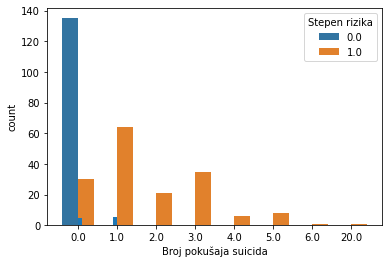

In [ ]:
numerical_feats = X1.dtypes[X1.dtypes != "object"].index
print(numerical_feats)
sb.countplot(x='Broj pokušaja suicida', hue='Stepen rizika', data=encode_data)
plt.hist(Y, density=True)
plt.show()

visokiStepen=data.loc[data['Stepen rizika']==1]

In [ ]:
def tacnost_po_klasi(mat_konf, klase):
    tacnost_i = []
    N = mat_konf.shape[0]
    for i in range(N):
        j = np.delete(np.array(range(N)),i) 
        TP = mat_konf[i,i]
        F = 0
        F = (sum(mat_konf[i,j]) + sum(mat_konf[j,i]))
        TN = sum(sum(mat_konf)) - F - TP
        tacnost_i.append((TP+TN)/sum(sum(mat_konf)))
        print('Za klasu ', klase[i], ' tacnost je: ', tacnost_i[i])
    tacnost_avg = np.mean(tacnost_i)
    return tacnost_avg

In [ ]:
def osetljivost_po_klasi(mat_konf, klase):
    osetljivost_i = []
    N = mat_konf.shape[0]
    for i in range(N):
        j = np.delete(np.array(range(N)),i) 
        TP = mat_konf[i,i]
        FN = sum(mat_konf[i,j])
        osetljivost_i.append(TP/(TP+FN))
        print('Za klasu ', klase[i], ' osetljivost je: ', osetljivost_i[i])
    osetljivost_avg = np.mean(osetljivost_i)
    return osetljivost_avg

In [ ]:
def evaluation_classif(conf_mat):
    TP = conf_mat[1, 1]
    TN = conf_mat[0, 0]
    FP = conf_mat[0, 1]
    FN = conf_mat[1, 0]
    precision = TP/(TP+FP)
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(TN+FP)
    F_score = 2*precision*sensitivity/(precision+sensitivity)
    print('precision: ', precision)
    print('accuracy: ', accuracy)
    print('sensitivity/recall: ', sensitivity)
    print('specificity: ', specificity)
    print('F score: ', F_score)

In [ ]:
#X=np.array(X)
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

#skaliranje vrednosti obelezja (standardizacija vrednosti)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = []
for c in [1, 10, 100]:
  for F in ['linear', 'rbf']:
    indexes = kf.split(X_train, Y_train)
    acc_tmp = []
    f1score_tmp = []
    fin_conf_mat = np.zeros((len(np.unique(Y_train)),len(np.unique(Y_train))))
    for train_index, test_index in indexes:
      classifier = SVC(C=c, kernel=F)
      classifier.fit(X_train.iloc[train_index,:], Y_train.iloc[train_index])
      y_pred = classifier.predict(X_train.iloc[test_index,:])
      acc_tmp.append(accuracy_score(Y_train.iloc[test_index], y_pred))
      f1score_tmp.append(f1_score(Y_train.iloc[test_index], y_pred))               
      fin_conf_mat += confusion_matrix(Y_train.iloc[test_index], y_pred, labels=labels_y)
    print('za parametre C=', c, ', kernel=', F, ' tacnost je: ', np.mean(acc_tmp), 'F1 skor je: ', np.mean(f1score_tmp),
                  ' a mat. konf. je:')
    print(fin_conf_mat)
    acc.append(np.mean(acc_tmp))
print('najbolja tacnost je u iteraciji broj: ', np.argmax(acc))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
indexes = kf.split(X_train, Y_train)
fin_conf_mat = np.zeros((len(np.unique(Y)),len(np.unique(Y))))
for train_index, test_index in indexes:
    svm = SVC(C=1, kernel='linear')
    svm.fit(X_train.iloc[train_index,:], Y_train.iloc[train_index])
    y_pred = svm.predict(X_train.iloc[test_index,:])
    #print(accuracy_score(Y_train.iloc[test_index], y_pred))
    fin_conf_mat += confusion_matrix(Y_train.iloc[test_index], y_pred)
#print(classification_report(Y_test, y_pred))
print('Konacna matrica konfuzije: \n', fin_conf_mat)
#print('Prosecna tacnost je: ', tacnost_po_klasi(fin_conf_mat, encode_data.iloc[:,-1].unique()))
#print('Prosecna osetljivost je: ', osetljivost_po_klasi(fin_conf_mat, encode_data.iloc[:,-1].unique()))
#print(evaluation_classif(fin_conf_mat))


In [ ]:
svm=SVC(C=1, kernel='linear')
svm.fit(X_train, Y_train)
pred=svm.predict(X_test)
print(confusion_matrix(Y_test, pred))
#print("Tacnost: ",accuracy_score(Y_test, pred))
#print('Preciznost: ',precision_score(Y_test, pred))
print(classification_report(Y_test, pred))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = []
for m in ['hamming', 'euclidean']:
  for i in range(1, 10):
    indexes = kf.split(X_train, Y_train)
    f1score_tmp = []
    acc_tmp = []
    fin_conf_mat = np.zeros((len(np.unique(Y_train)),len(np.unique(Y_train))))
    for train_index, test_index in indexes:
      classifier = KNeighborsClassifier(n_neighbors=i, metric=m)
      classifier.fit(X_train.iloc[train_index,:], Y_train.iloc[train_index])
      y_pred = classifier.predict(X_train.iloc[test_index,:])
      acc_tmp.append(accuracy_score(Y_train.iloc[test_index], y_pred))
      f1score_tmp.append(f1_score(Y_train.iloc[test_index], y_pred))               
      fin_conf_mat += confusion_matrix(Y_train.iloc[test_index], y_pred, labels=labels_y)
    print('za parametar k=', i, 'metriku', m, 'tacnost je', np.mean(acc_tmp), 'F1 skor je: ', np.mean(f1score_tmp), 'a matrica konfuzije je ')
    print(fin_conf_mat)
    acc.append(np.mean(acc_tmp))
print('najbolja tacnost je u iteraciji broj: ', np.argmax(acc))

za parametar k= 1 metriku hamming tacnost je 0.8625 F1 skor je:  0.8720831728917983 a matrica konfuzije je 
[[114.  22.]
 [ 11.  93.]]
za parametar k= 2 metriku hamming tacnost je 0.85 F1 skor je:  0.8455412683729057 a matrica konfuzije je 
[[100.  36.]
 [  0. 104.]]
za parametar k= 3 metriku hamming tacnost je 0.9041666666666666 F1 skor je:  0.9100358639182169 a matrica konfuzije je 
[[117.  19.]
 [  4. 100.]]
za parametar k= 4 metriku hamming tacnost je 0.8916666666666668 F1 skor je:  0.8936382245205774 a matrica konfuzije je 
[[111.  25.]
 [  1. 103.]]
za parametar k= 5 metriku hamming tacnost je 0.9291666666666668 F1 skor je:  0.9333152337858222 a matrica konfuzije je 
[[120.  16.]
 [  1. 103.]]
za parametar k= 6 metriku hamming tacnost je 0.9 F1 skor je:  0.9012820512820513 a matrica konfuzije je 
[[112.  24.]
 [  0. 104.]]
za parametar k= 7 metriku hamming tacnost je 0.9125 F1 skor je:  0.9171131700543466 a matrica konfuzije je 
[[118.  18.]
 [  3. 101.]]
za parametar k= 8 metrik

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
indexes = kf.split(X_train, Y_train)
acc = []
fin_conf_mat = np.zeros((len(np.unique(Y)),len(np.unique(Y))))
for train_index, test_index in indexes:
    knn = KNeighborsClassifier(n_neighbors=5, metric='hamming')
    knn.fit(X_train.iloc[train_index,:], Y_train.iloc[train_index])
    y_pred = knn.predict(X_train.iloc[test_index,:])
    #print(accuracy_score(Y_train.iloc[test_index], y_pred))
    fin_conf_mat += confusion_matrix(Y_train.iloc[test_index], y_pred)
#print(classification_report(Y_test, y_pred))
print('Konacna matrica konfuzije: \n', fin_conf_mat)
print('Prosecna tacnost je: ', tacnost_po_klasi(fin_conf_mat, encode_data.iloc[:,-1].unique()))
print('Prosecna osetljivost je: ', osetljivost_po_klasi(fin_conf_mat, encode_data.iloc[:,-1].unique()))
print(evaluation_classif(fin_conf_mat))

Konacna matrica konfuzije: 
 [[104.   0.]
 [ 15. 121.]]
Za klasu  1.0  tacnost je:  0.9375
Za klasu  0.0  tacnost je:  0.9375
Prosecna tacnost je:  0.9375
Za klasu  1.0  osetljivost je:  1.0
Za klasu  0.0  osetljivost je:  0.8897058823529411
Prosecna osetljivost je:  0.9448529411764706
precision:  1.0
accuracy:  0.9375
sensitivity/recall:  0.8897058823529411
specificity:  1.0
F score:  0.9416342412451362
None


In [ ]:
knn=KNeighborsClassifier(n_neighbors=5, metric='hamming')
knn.fit(X_train, Y_train)
pred=knn.predict_proba(X_test)
#print(confusion_matrix(Y_test, pred))
#print("Tacnost: ",accuracy_score(Y_test, pred))
#print('Preciznost: ',precision_score(Y_test, pred))
#print(classification_report(Y_test, pred))
#fig = plot_confusion_matrix(knn, X_test, Y_test, display_labels=knn.classes_)
#fig.figure_.suptitle("Confusion Matrix")
#plt.show()
#score = f1_score(Y_test, pred, average='binary')
#print('F-Measure: %.3f' % score)
auc_knn = roc_auc_score(Y_test, pred[:,1])
fpr, tpr, threshold = roc_curve(Y_test, pred[:, 1])
print('ROC AUC: %f' % auc_knn)
print(pred)
print('th: ', threshold)
#print('recall: ', tpr)
#print('sprecifity: ', 1-fpr)
plt.plot(fpr, tpr,label="AUC="+str(auc_knn))
print('fpr: ', fpr)
print('tpr: ', tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC curve')
plt.legend(loc=4)
plt.show()
#"""""results = permutation_importance(knn, X_train, Y_train, scoring='accuracy')
# get importance
#importance = results.importances_mean
# summarize feature importance
#for i,v in enumerate(importance):
#	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc = []
for c in ['gini', 'entropy']:
  for i in range(5, 20):
    indexes = kf.split(X_train, Y_train)
    f1score_tmp = []
    acc_tmp = []
    fin_conf_mat = np.zeros((len(np.unique(Y_train)),len(np.unique(Y_train))))
    for train_index, test_index in indexes:
      classifier = DecisionTreeClassifier(criterion = c, max_depth=i)
      classifier.fit(X_train.iloc[train_index,:], Y_train.iloc[train_index])
      y_pred = classifier.predict(X_train.iloc[test_index,:])
      acc_tmp.append(accuracy_score(Y_train.iloc[test_index], y_pred))
      f1score_tmp.append(f1_score(Y_train.iloc[test_index], y_pred))               
      fin_conf_mat += confusion_matrix(Y_train.iloc[test_index], y_pred, labels=labels_y)
    print('za parametar max_depth=', i, 'kriterijum', c, 'tacnost je', np.mean(acc_tmp), 'F1 skor je: ', np.mean(f1score_tmp), 'a matrica konfuzije je ')
    print(fin_conf_mat)
    acc.append(np.mean(acc_tmp))
print('najbolja tacnost je u iteraciji broj: ', np.argmax(acc))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
indexes = kf.split(X1_train, Y1_train)

fin_conf_mat_dt = np.zeros((len(np.unique(Y1_train)),len(np.unique(Y1_train))))

for train_index, test_index in indexes:
    classifier = DecisionTreeClassifier(max_depth=5)
    classifier.fit(X1_train.iloc[train_index,:], Y1_train.iloc[train_index])
    plt.figure(figsize=(16,9), dpi=300)
    tree.plot_tree(classifier)
    Y_pred = classifier.predict(X1_train.iloc[test_index,:])
    conf_mat = confusion_matrix(Y1_train.iloc[test_index], Y_pred)
    print(conf_mat)
    fin_conf_mat_dt += conf_mat
print('finalna matrica za stablo odluke je: ')
print(fin_conf_mat_dt)
print('procenat pogođenih uzoraka je: ', np.trace(fin_conf_mat_dt)/sum(sum(fin_conf_mat_dt))*100, '%')


********************************** ****************

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp_clf = MLPClassifier()
param_grid = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100, 150],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
grid = GridSearchCV(mlp_clf, param_grid, n_jobs= -1, cv=5)
grid.fit(X_train, Y_train)

print(grid.best_params_) 

{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 100, 50), 'learning_rate': 'adaptive', 'max_iter': 150, 'solver': 'sgd'}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (150) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
mlp_clf = MLPClassifier()
classifier = MLPClassifier(hidden_layer_sizes=(150, 100, 50), activation='tanh',
                          solver='sgd', batch_size=32, learning_rate='adaptive', 
                          learning_rate_init=0.0001, max_iter=150, alpha=0.05, shuffle=True,
                          random_state=1, early_stopping=True, n_iter_no_change=10,
                          validation_fraction=0.1, verbose=False)
fitMethod=classifier.fit(X_train, Y_train)
y_pred = classifier.predict(X_test)
print('Accuracy: {:.2f}'.format(accuracy_score(Y_test, y_pred)))
auc = roc_auc_score(Y_test, y_pred)
print('ROC AUC: %f' % auc)
precision = precision_score(Y_test, y_pred)
print('Precision: %f' % precision)
fig = plot_confusion_matrix(classifier, X_test, Y_test, display_labels=classifier.classes_)
fig.figure_.suptitle("Confusion Matrix")
plt.show()
print(classification_report(Y_test, y_pred))
plt.plot(classifier.loss_curve_)
plt.title("Loss Curve", fontsize=14)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

U ovom delu je radjeno kao na vezbama; rezultati su losiji u poredjenju sa prethodnim

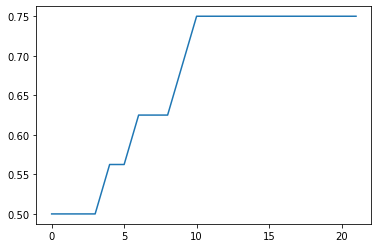

0.725


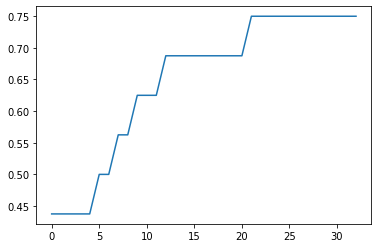

0.8125


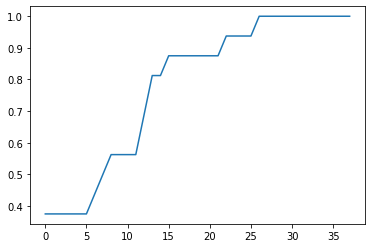

0.8625
Konacna matrica konfuzije: 
 [[ 91.  13.]
 [ 35. 101.]]
Procenat tacno predvidjenih:  0.8
Za klasu  1.0  tacnost je:  0.8
Za klasu  0.0  tacnost je:  0.8
Prosecna tacnost je:  0.8
precision:  0.8859649122807017
accuracy:  0.8
sensitivity/recall:  0.7426470588235294
specificity:  0.875
F score:  0.808
None


In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
indexes = kf.split(X_train, Y_train)
acc = []
fin_conf_mat = np.zeros((len(np.unique(Y)),len(np.unique(Y))))
for train_index, test_index in indexes:
    classifier = MLPClassifier(hidden_layer_sizes=(120, 80, 40), activation='tanh',
                          solver='adam', batch_size=32, learning_rate='adaptive', 
                          learning_rate_init=0.0001, max_iter=100, alpha=0.05, shuffle=True,
                          random_state=1, early_stopping=True, n_iter_no_change=10,
                          validation_fraction=0.1, verbose=False)
    classifier.fit(X_train.iloc[train_index,:], Y_train.iloc[train_index])
    y_pred = classifier.predict(X_train.iloc[test_index,:])
    plt.figure
    plt.plot(classifier.validation_scores_)
    #plt.plot(classifier.loss_curve_)
    plt.show()
    print(accuracy_score(Y_train.iloc[test_index], y_pred))
    fin_conf_mat += confusion_matrix(Y_train.iloc[test_index], y_pred)

print('Konacna matrica konfuzije: \n', fin_conf_mat)
print('Procenat tacno predvidjenih: ', sum(np.diag(fin_conf_mat))/sum(sum(fin_conf_mat)))
print('Prosecna tacnost je: ', tacnost_po_klasi(fin_conf_mat, encode_data.iloc[:,-1].unique()))
#print('Prosecna osetljivost je: ', osetljivost_po_klasi(fin_conf_mat, encode_data.iloc[:,-1].unique()))
print(evaluation_classif(fin_conf_mat))

In [ ]:
import sklearn
model=Sequential()
model.add(Dense(18, input_shape=(X_train.shape[1],), activation='relu')) # Add an input shape! (features,)
model.add(Dense(16, activation='relu'))
model.add(Dense(6,activation="relu"))
model.add(Dense(1, activation='sigmoid'))
model.summary() 

model.compile(optimizer="RMSprop", loss="binary_crossentropy", metrics=["accuracy"])
# early stopping callback
# This callback will stop the training when there is no improvement in  
# the validation loss for 10 consecutive epochs.  
es = EarlyStopping(monitor='val_accuracy', 
                                   mode='max', #bez minimizacije tacnosti 
                                   patience=10,
                                   restore_best_weights=True)

fitMethod = model.fit(X_train, Y_train, callbacks=[es], epochs=100, batch_size=16, validation_split=0.2, shuffle=True, verbose=1)

predProb=model.predict(X_test, verbose=0)
print(predProb)
predProb = predProb.flatten()
print(predProb.round(2))

# extract the predicted class labels
yPred = np.where(predProb > 0.5, 1, 0)
print(classification_report(Y_test, yPred))
#_, accuracy = model.evaluate(X_train, Y_train) #ovo je tacnost u procesu treniranja, tj. tacnost za podatke iz skupa za obuku
#print('Accuracy: %.2f' % (accuracy*100))
#_, accuracy_test = model.evaluate(X_test, predProb) #ovo je tacnost u procesu treniranja, tj. tacnost za podatke iz skupa za obuku
#print('Accuracy: %.2f' % (accuracy_test*100))
print(yPred)
# accuracy: (tp + tn) / (p + n)
accuracy_nn = accuracy_score(Y_test, yPred)
print('Accuracy: %f' % accuracy_nn)
# precision tp / (tp + fp)
precision = precision_score(Y_test, yPred)
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(Y_test, yPred)
print('Recall: %f' % recall)
# ROC AUC
auc = roc_auc_score(Y_test, yPred)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Y_test, yPred)
print(matrix)


# list all data in history
print(fitMethod.history.keys())
# summarize history for accuracy
plt.plot(fitMethod.history['accuracy'])
plt.plot(fitMethod.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(fitMethod.history['loss'])
plt.plot(fitMethod.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


[0.02 0.96 0.03 0.03 1.   0.07 0.03 0.08 0.87 0.1  0.39 1.   0.06 0.93
 1.   1.   0.09 1.   0.08 1.   1.   0.06 0.05 0.04 0.14 0.95 0.1  1.
 0.92 1.   0.08 0.03 0.84 1.   0.05 1.   0.07 1.   0.08 0.02 0.73 1.
 0.02 0.03 1.   0.09 0.02 0.72 0.1  1.   0.99 0.05 0.09 1.   0.99 1.
 0.96 0.01 1.   1.   1.  ]


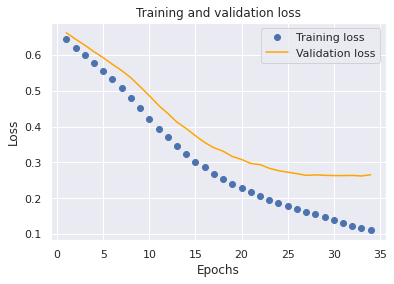

In [ ]:
history_dict = fitMethod.history
# Learning curve(Loss)
# training and validation loss by epoch

# loss
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

# range of X (no. of epochs)
epochs = range(1, len(loss_values) + 1) 

# plot
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()